In [1]:
#| default_exp data

In [2]:
#|export 
from fastcore.all import *
path = Path('../static')
path.mkdir(exist_ok=True)

In [3]:
#| hide
from nbdev.showdoc import *

## Text Data Pipeline:

1. Downloaded Shakespeare text data, from [Karpathy's nanogpt](https://github.com/karpathy/build-nanogpt) 
1. Built a character-level Tokenizer (65 unique chars)
1. Created GPTDataset for non-overlapping sequence chunks
1. Made get_text_dl() function returning train/valid dataloaders with 90/10 split


In [4]:
#|export 
urlsave("https://raw.githubusercontent.com/karpathy/build-nanogpt/refs/heads/master/input.txt", path) 

Path('../static/input.txt')

In [5]:
#|export
from typing import List
class Tokenizer:
    """
    Maps each char to unique index. It have some key attributes i.e.
    1. **voacb**: where it maped to all the char present text field
    1. **encode**: to encode given string to list of tokens
    1. **decode**: to decode given tokens to str
    1. **c2i** and **i2c**: helper function to convert char to tokens and tokens to char respectively
    """
    def __init__(self):
        self.setup_vocab()

    def setup_vocab(self):
        with open(path/'input.txt', 'r') as file:
            self.txt = file.read()

        self.vocab = sorted(list(set(list(self.txt))))
        #print(f"After reading file got the vocab of shape : {len(self.vocab)}")

    def c2i(self, ch:str) -> int:
        """
        returns index of char ch from vocab
        """
        return self.vocab.index(ch)

    def i2c(self, idx:int) -> str:
        """
        returns char from vocab given index
        """
        return self.vocab[idx]

    def encode(self, inp:str) -> List[int]:
        """
        returns the encoded string
        """
        return [self.c2i(i) for i in inp]

    def decode(self, inp:List[int]) -> str:
        """
        returns the string represntation of the
        """
        return ''.join([self.i2c(i) for i in inp])

tokenizer = Tokenizer()

In [6]:
s = 'abc'
assert tokenizer.decode(tokenizer.encode(s))  == s

The tokenizer is loss less.

### DataLoader
The Dataset should be of **non-overlapping chunks**:
1. `__init__` - store the encoded text and config (seq_len, etc.)
1. `__len__`: return `len(encoded_text) // seq_len - 1` (divide, not subtract)
1. `__getitem__`: use `idx * seq_len` as the starting position

In [7]:
#|export
#|hide
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):
    def __init__(self, text, seq_len:int):
        self.text = text
        self.seq_len = seq_len
        self.encoded_text = tokenizer.encode(text)

    def __len__(self):
        return len(self.encoded_text) // self.seq_len -1

    def __getitem__(self, idx):
        inp = self.encoded_text[idx * self.seq_len : (idx + 1) * self.seq_len]
        op = self.encoded_text[idx * self.seq_len + 1 : (idx + 1) * self.seq_len + 1]
        return torch.tensor(inp), torch.tensor(op)

In [8]:
#|export
def get_text_dl(bs:int=64, seq_len:int=128):
    split_idx = int(len(tokenizer.txt) * 0.9)                         #split text with 9:
    train_dataset = GPTDataset(tokenizer.txt[:split_idx], seq_len )
    val_dataset = GPTDataset(tokenizer.txt[split_idx:], seq_len)

    return {
        'train': DataLoader(train_dataset, batch_size=bs, shuffle=True),
        'valid': DataLoader(val_dataset, batch_size=bs, shuffle=False)
    }

In [9]:
dl = get_text_dl()
for x, y in dl['train']:
    break
assert x.shape == y.shape

In [10]:
x[0, :10], y[0,:10]

(tensor([53, 61, 57,  6,  1, 53, 56,  1, 58, 46]),
 tensor([61, 57,  6,  1, 53, 56,  1, 58, 46, 39]))

## Vision Fashion MNIST

**Steps:**

1. **Define transforms** - Convert images to tensors, normalize if needed

1. **Load Fashion MNIST dataset** - Use `torchvision.datasets.FashionMNIST()` for train and test splits

1. **Create DataLoaders** - Wrap datasets with DataLoader, set batch_size and shuffle=True for training

1. **Verify** - Check one batch to confirm shape (bs, 1, 28, 28) and labels (0-9)




In [11]:
#| export
from torchvision import datasets, transforms
datasets.FashionMNIST(path, download=True)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../static
    Split: Train

In [12]:
path.ls()

(#2) [Path('../static/input.txt'),Path('../static/FashionMNIST')]

In [13]:
#|export 
import numpy as np
import matplotlib.pyplot as plt

def show_images(im, label=None, figsize=(3,3)):  # Increase size
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    if isinstance(im, torch.Tensor):
        if im.shape[0] == 1:
            im = im.squeeze(0)
        elif im.shape[0] == 3:
            im = im.permute(1, 2, 0)
        im = im.numpy()

    ax.imshow(im, cmap='gray')
    if label: ax.set_title(f"Label: {label}")
    ax.axis('off')
    
    plt.show()  # Remove tight_layout()

In [14]:
train_ds = datasets.FashionMNIST(path, train=True, transform=transforms.ToTensor())
valid_ds = datasets.FashionMNIST(path, transform=transforms.ToTensor())
im, lbl = train_ds[0]
type(im), lbl

(torch.Tensor, 9)

In [15]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32)

In [16]:
for x, y in train_dl:
    break

In [17]:
len(valid_ds)

60000

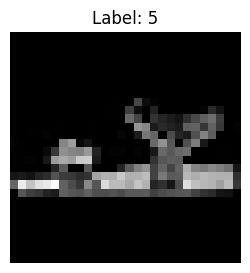

In [18]:
show_images(*valid_ds[-1])

A helper function for retruning fashion mnist classification data

In [19]:
#|export
def get_vision_classifier_dl(bs:int=64):
    im_path = path/'FashionMNIST'

    train_ds = datasets.FashionMNIST(im_path, train=True, transform=transforms.ToTensor())
    valid_ds = datasets.FashionMNIST(im_path, transform=transforms.ToTensor())

    return {
        'train': DataLoader(train_ds, batch_size=bs, shuffle=True),
        'valid': DataLoader(valid_ds, batch_size=bs)
    }

In [20]:
dl = get_vision_classifier_dl()
for x, y in dl['valid']:
    break
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

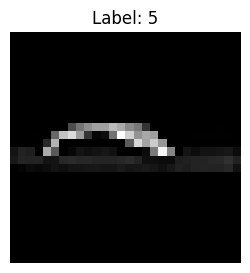

In [21]:
show_images(x[-1], y[-1])

### Generate Synthetic Captions

- Image captioning descriptions for Fashion MNIST
- Examples: "ankle boot", "pullover sweater", "sneaker"
- Character-level format

In [22]:
#|export
# captions of MNIST data
captions = {
    0: ["t-shirt", "tee shirt", "tee", "short sleeve shirt", "casual shirt", 
        "cotton tee", "basic tee", "crew neck shirt", "top", "shirt",
        "simple tee", "everyday shirt", "round neck tee", "plain tee", "short sleeve top",
        "casual top", "basic shirt", "t shirt", "crew tee", "cotton shirt"],
    
    1: ["trouser", "trousers", "pants", "slacks", "dress pants",
        "long pants", "formal pants", "casual pants", "bottoms", "leg wear",
        "straight pants", "fitted pants", "work pants", "everyday pants", "pant",
        "classic trousers", "regular pants", "full length pants", "basic pants", "standard trousers"],
    
    2: ["pullover", "sweater", "jumper", "knit sweater", "warm sweater",
        "pullover sweater", "casual sweater", "knitted top", "knitwear", "woolen top",
        "crew neck sweater", "basic pullover", "winter top", "cozy sweater", "knit top",
        "long sleeve sweater", "casual pullover", "everyday sweater", "simple sweater", "pullover top"],
    
    3: ["dress", "frock", "gown", "one piece dress", "casual dress",
        "simple dress", "everyday dress", "summer dress", "day dress", "basic dress",
        "long dress", "short dress", "women's dress", "classic dress", "plain dress",
        "fitted dress", "loose dress", "comfortable dress", "standard dress", "regular dress"],
    
    4: ["coat", "jacket", "overcoat", "long coat", "winter coat",
        "warm coat", "outer wear", "heavy jacket", "formal coat", "trench coat",
        "long jacket", "full coat", "winter jacket", "outerwear", "layering piece",
        "cold weather coat", "classic coat", "tailored coat", "button coat", "dress coat"],
    
    5: ["sandal", "sandals", "open toe shoe", "summer shoe", "casual sandal",
        "flat sandal", "beach sandal", "simple sandal", "everyday sandal", "comfortable sandal",
        "strappy sandal", "basic sandal", "slip on sandal", "warm weather shoe", "open shoe",
        "light sandal", "walking sandal", "casual footwear", "easy sandal", "relaxed sandal"],
    
    6: ["shirt", "button shirt", "dress shirt", "collared shirt", "formal shirt",
        "long sleeve shirt", "casual shirt", "button up", "button down", "work shirt",
        "everyday shirt", "classic shirt", "plain shirt", "simple shirt", "standard shirt",
        "fitted shirt", "regular shirt", "basic shirt", "office shirt", "collar shirt"],
    
    7: ["sneaker", "sneakers", "trainer", "running shoe", "athletic shoe",
        "sport shoe", "casual sneaker", "tennis shoe", "gym shoe", "walking shoe",
        "everyday sneaker", "comfortable sneaker", "trainers", "sports sneaker", "active shoe",
        "rubber shoe", "lace up sneaker", "low top sneaker", "basic sneaker", "street shoe"],
    
    8: ["bag", "handbag", "purse", "shoulder bag", "tote bag",
        "carry bag", "everyday bag", "casual bag", "hand bag", "fashion bag",
        "women's bag", "shopping bag", "simple bag", "basic bag", "travel bag",
        "carryall", "satchel", "daily bag", "practical bag", "accessory bag"],
    
    9: ["ankle boot", "boot", "short boot", "bootie", "ankle bootie",
        "low boot", "casual boot", "everyday boot", "simple boot", "leather boot",
        "walking boot", "comfortable boot", "fitted boot", "standard boot", "basic boot",
        "ankle high boot", "short ankle boot", "classic boot", "urban boot", "stylish boot"]
}

In [23]:
all_chars = set(''.join([caption for v in captions.values() for caption in v]))
assert all([i in tokenizer.vocab for i in all_chars])

In [41]:
max_len = max([len(list(caption)) for v in captions.values() for caption in v])
max_len

19

In [24]:
#|export
import random
assert set([len(i) for i in captions.values()]) == {len(captions[0])}
rand_lbl = lambda : random.randint(0, len(captions[0])-1)

In [25]:
rand_lbl()

10

#### Dataset for Fashion MNIST

Key methods to implement:

1. __init__: Load Fashion MNIST, store captions dict and tokenizer
1. __len__: Return dataset size
1. __getitem__: Gets image, randomly picks caption from the class, tokenizes, and returns:
    - Input: tokens[:-1] (0 to n-1)
    - Target: tokens[1:] (1 to n)

In [26]:
#|export
class MNISTDataset(Dataset):
    def __init__(self, tokenizer, fn_path:Path, split='train', captions=captions):
        self.tokenizer = tokenizer
        self.captions = captions
        self.ds = datasets.FashionMNIST(fn_path, train=split == 'train', transform=transforms.ToTensor())

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        im, lbl = self.ds[idx]
        caption = self.captions[lbl][rand_lbl()] + '\n'         # Add '\n' here showing eos for the caption data
        tokens = torch.tensor(self.tokenizer.encode(caption))

        # Create input and target sequences
        input_tokens = tokens[:-1]
        target_tokens = tokens

        return im, input_tokens, target_tokens

In [27]:
train_ds = MNISTDataset(tokenizer, path)
im, lbl_inp, lbl_tgt = train_ds[0]
im.shape, lbl_inp, lbl_tgt

(torch.Size([1, 28, 28]),
 tensor([40, 53, 53, 58]),
 tensor([40, 53, 53, 58,  0]))

In [44]:
s = 'abv'
s[:-1]

'ab'

Check all the tokens in the caption length equal or less that max len of the tokens.

In [47]:
assert all([len(lbl_inp[:-1]) <= max_len for _, lbl_inp, _ in train_ds])
test_ds = MNISTDataset(tokenizer, path, split='test')
assert all([len(lbl_inp[:-1]) <= max_len for _, lbl_inp, _ in test_ds])

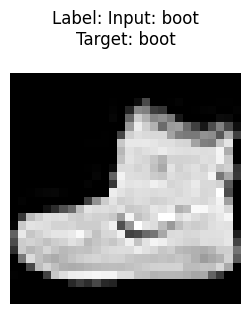

In [28]:
show_images(im, f"Input: {tokenizer.decode(lbl_inp)}\nTarget: {tokenizer.decode(lbl_tgt)}")

In [29]:
#|export
from torch.nn.utils.rnn import pad_sequence

def collate_fn_multimodal(batch):
    """Collate function to handle variable length sequences"""
    images, input_seqs, target_seqs = zip(*batch)
    
    # Stack images
    images = torch.stack(images)
    
    # Pad input and target sequences
    input_seqs_padded = pad_sequence(input_seqs, batch_first=True, padding_value=0)
    target_seqs_padded = pad_sequence(target_seqs, batch_first=True, padding_value=0)
    
    return images, input_seqs_padded, target_seqs_padded

# Updated dataloader function
def get_mnist_caption_dl(tokenizer, fn_path, batch_size=64):
    """
    Creates train and validation dataloaders for Fashion MNIST with captions.
    Returns dict with 'train' and 'valid' DataLoaders.
    """
    train_ds = MNISTDataset(tokenizer, fn_path, split='train')
    valid_ds = MNISTDataset(tokenizer, fn_path, split='valid')

    return {
        'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_multimodal),
        'valid': DataLoader(valid_ds, batch_size=batch_size, collate_fn=collate_fn_multimodal)
    }

In [32]:
dls = get_mnist_caption_dl(tokenizer, path)
ims, inp, tgt = next(iter(dls['train']))

assert ims.shape[0] == inp.shape[0] == tgt.shape[0]
assert ims.shape[1:] == torch.Size([1, 28, 28])


In [34]:
inp.shape, tgt.shape

(torch.Size([64, 18]), torch.Size([64, 19]))

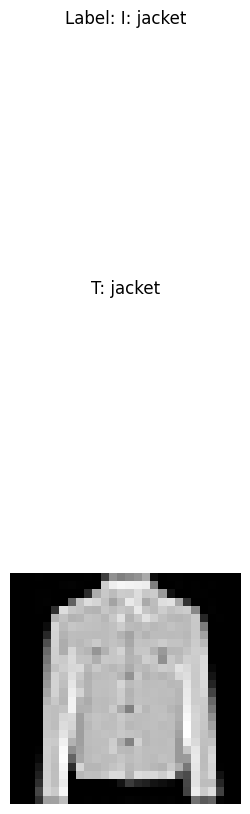

In [33]:
show_images(ims[0], f"I: {tokenizer.decode(inp[0])}\nT: {tokenizer.decode(tgt[0])}")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()